In [2]:
%reload_ext autoreload
%autoreload 2


%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

import scienceplots
#change the default matplotlib style sheet
matplotlib.style.use("science")

import healpy as hp

import numpy as np

from plancklens import shts

import pathlib

In [3]:
from plancklens import utils
copy = lambda x, size: utils.alm_copy(x, lmax = hp.Alm.getlmax(size))

In [4]:
import scipy


def bin_theory(cl, lmin = 10, lmax = 6000, deltal = 150):
    bin_edges = np.arange(lmin, lmax, deltal)
    l = np.arange(len(cl))
    lcl = l*cl
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, lcl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    cents = (bin_edges[1:] + bin_edges[:-1]) / 2
    return cents, cl


In [5]:
nside = 2048

direc = '/home/users/d/darwish/scratch/WEBSKY'
directory = pathlib.Path(direc)
kappa = hp.read_map(directory/"kap.fits").astype(float)
kappa_alm = shts.map2alm(kappa.copy(), lmax = 3*nside-1)

In [6]:
gmask_ud = np.load(f"../data/DESY3/gmask_ud_{nside}.npy")
area_gmask = gmask_ud.mean()*4*np.pi
Ngals = [2236462, 1599487, 1627408, 2175171, 1583679, 1494243]

In [7]:
directory_mask = "/home/users/d/darwish/ACTdr6xDESy3/products/60/data/lensing/2048/"
kappa_mask = np.load(f"{directory_mask}kappa_mask_2048.npy")
kappa_mask = hp.ud_grade(kappa_mask, nside_out = nside)

In [8]:
#f = "/Users/omard/Documents/projects/ACTdr6xDESy3/notebooks/nbodywebsky/0_mock_buzzard.txt"
#l_decoupled, cl_decoupled, shotM, eld, cld, shotD = np.loadtxt(f).T
#f = "/Users/omard/Documents/projects/ACTdr6xDESy3/notebooks/nbodywebsky/0_mice.txt"
#lbin, clbin, shotbin = np.loadtxt(f).T

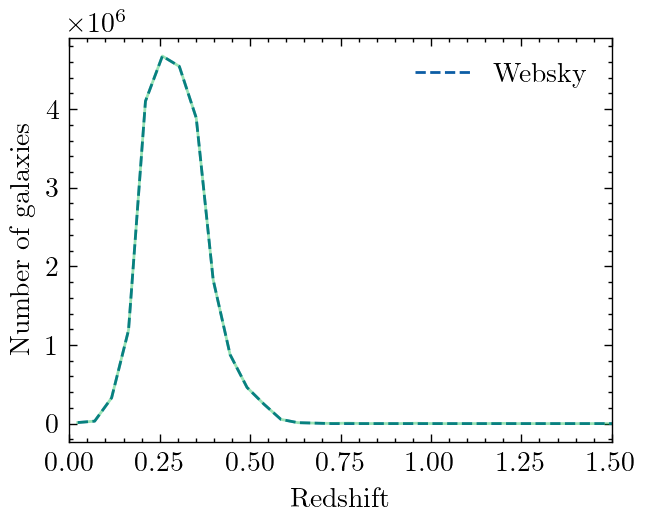

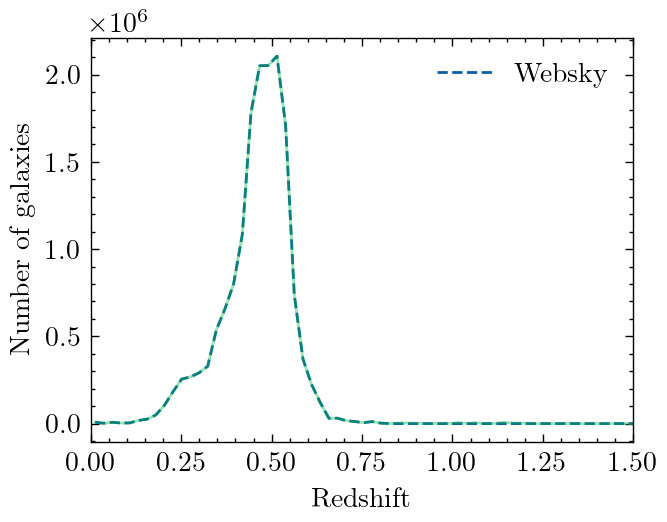

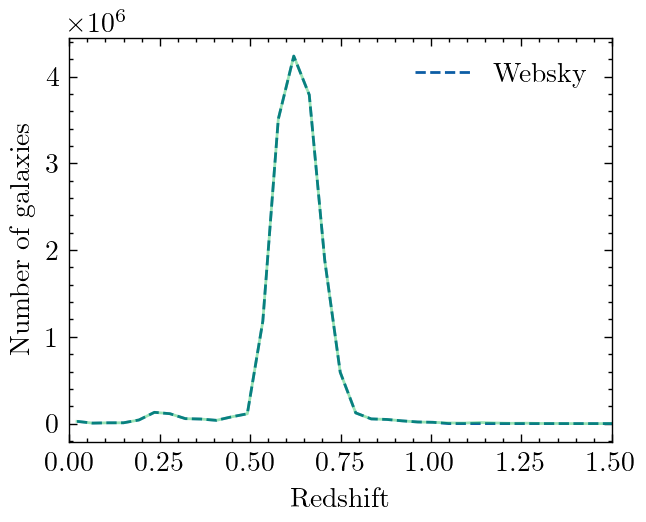

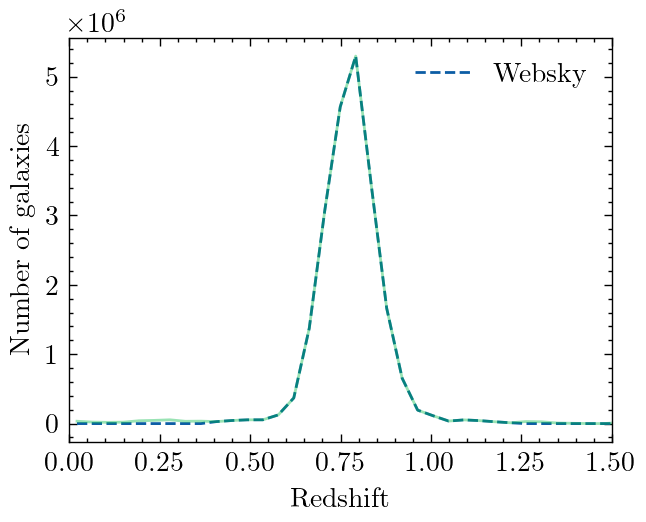

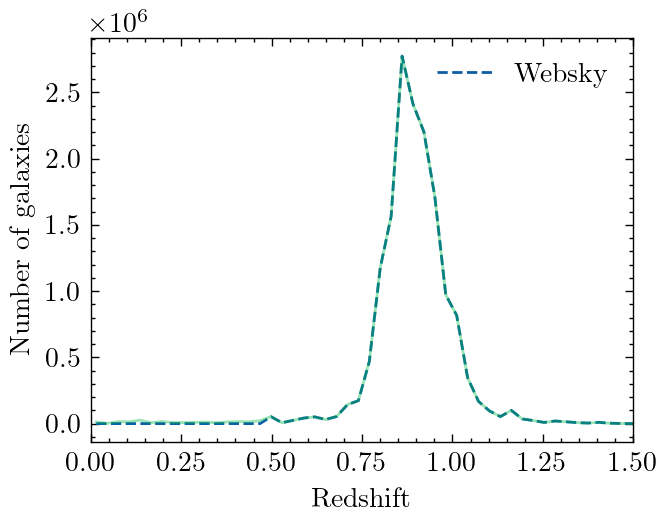

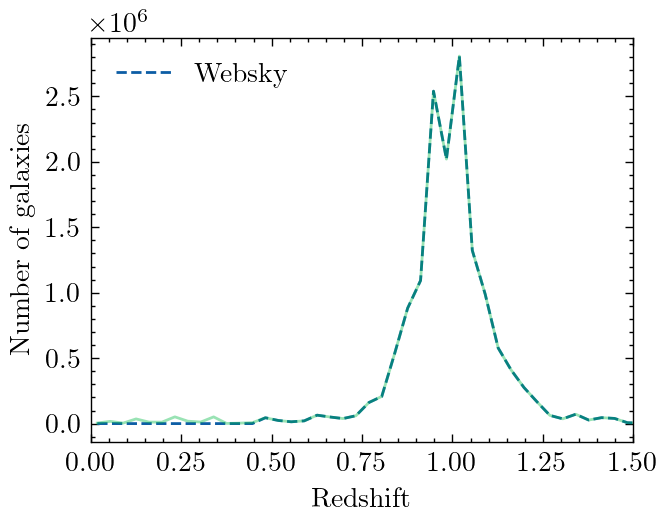

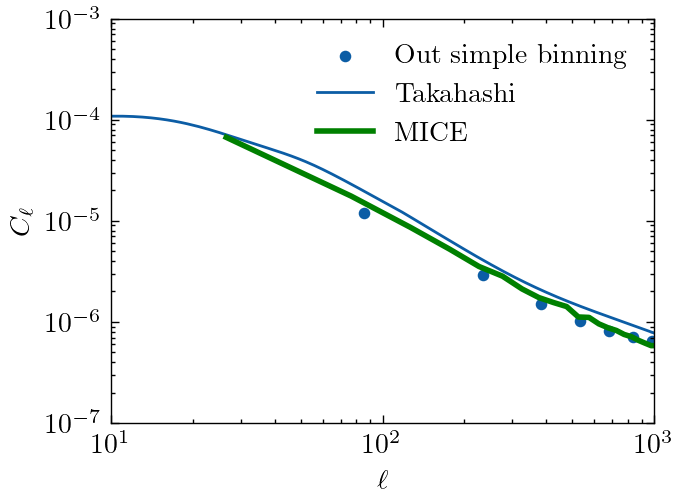

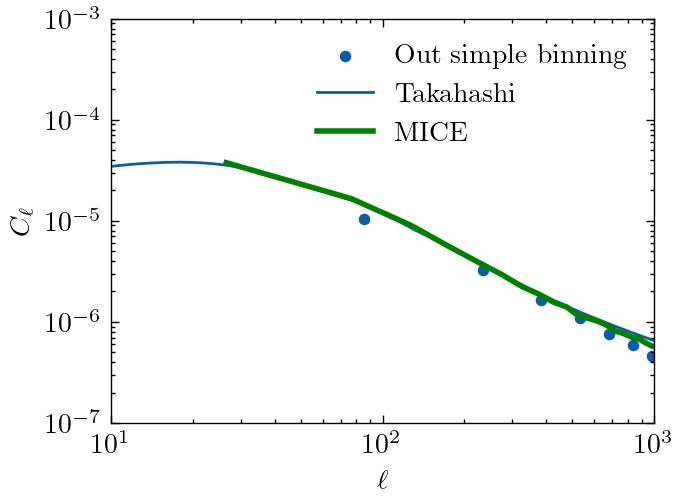

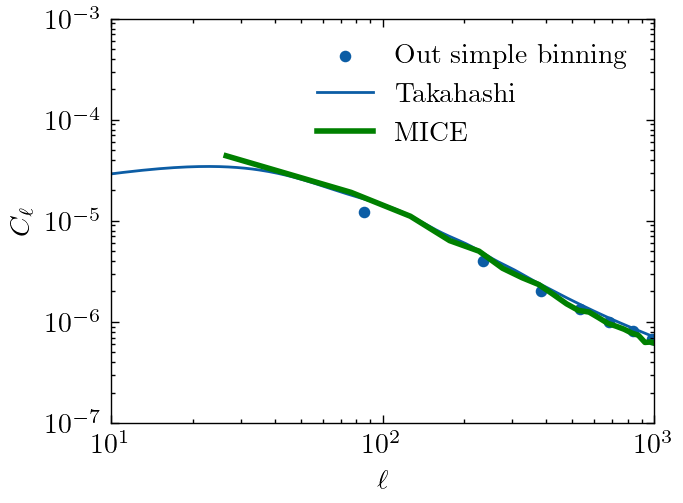

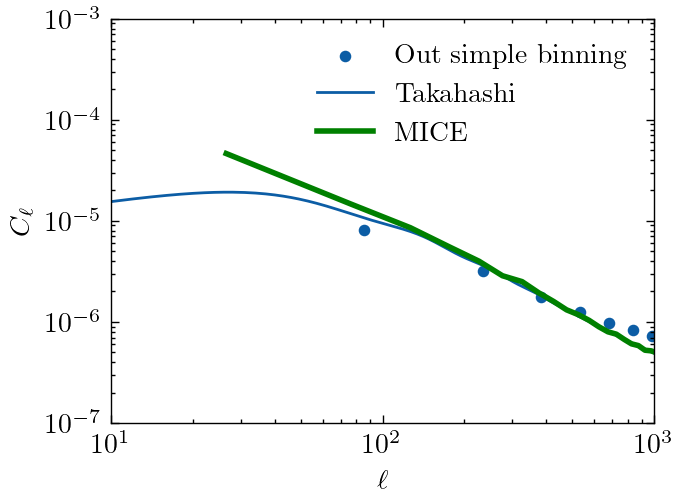

In [13]:
directory = "../data/maps/"


indices = range(6)

for zbin in indices:
    z, nz = np.loadtxt(directory+f"nz_websky_zbin_{zbin}.txt").T
    zin, nzin = np.loadtxt(directory+f"nz_input_zbin_{zbin}.txt").T

    plt.plot(z, nz, label = "Websky", ls = "--")
    plt.plot(zin, nzin*9.956850297163822, alpha = 0.4)
    plt.xlim(0., 1.5)
    plt.xlabel("Redshift")
    plt.ylabel("Number of galaxies")
    plt.legend()
    plt.show()

deltas = {}

for zbin in indices:
    mappa = hp.read_map(directory+f"websky_map_zbin_{zbin}.fits")
    mean_mask = 1
    delta = mappa/mappa.mean()-1
    alms_out = shts.map2alm(delta.copy(), lmax = 3*nside-1)
    deltas[zbin] = alms_out

    ls = np.arange(3*nside)

    theory = bin_theory(hp.alm2cl(alms_out)-1/(mappa.sum()/4/np.pi/mean_mask))

    el_fit, cl_fit = np.loadtxt(f"/home/users/d/darwish/ACTdr6xDESy3/actxdes/data/spectra_mnu_takahashi_fit/cl_gg_{zbin}_{zbin}.txt", unpack = True)

    f = f"/home/users/d/darwish/ACTdr6xDESy3/notebooks/mice/mice_gg_{zbin}.txt"
    lbin, clmice, kgmice, shotmice = np.loadtxt(f).T

    plt.scatter(*theory, label = "Out simple binning", s = 10)
    plt.plot(el_fit, cl_fit, label = "Takahashi")
    #plt.plot(l_decoupled, cl_decoupled-shotM, label = "Buzzard", lw = 2, color = "red")
    plt.loglog(lbin, clmice-shotmice, label = "MICE", lw = 2, color = "green")

    plt.ylim(1e-7, 1e-3)
    plt.xlim(10, 1000)
    plt.ylabel(r'$C_{\ell}$')
    plt.xlabel(r'$\ell$')
    plt.legend()
    plt.show()

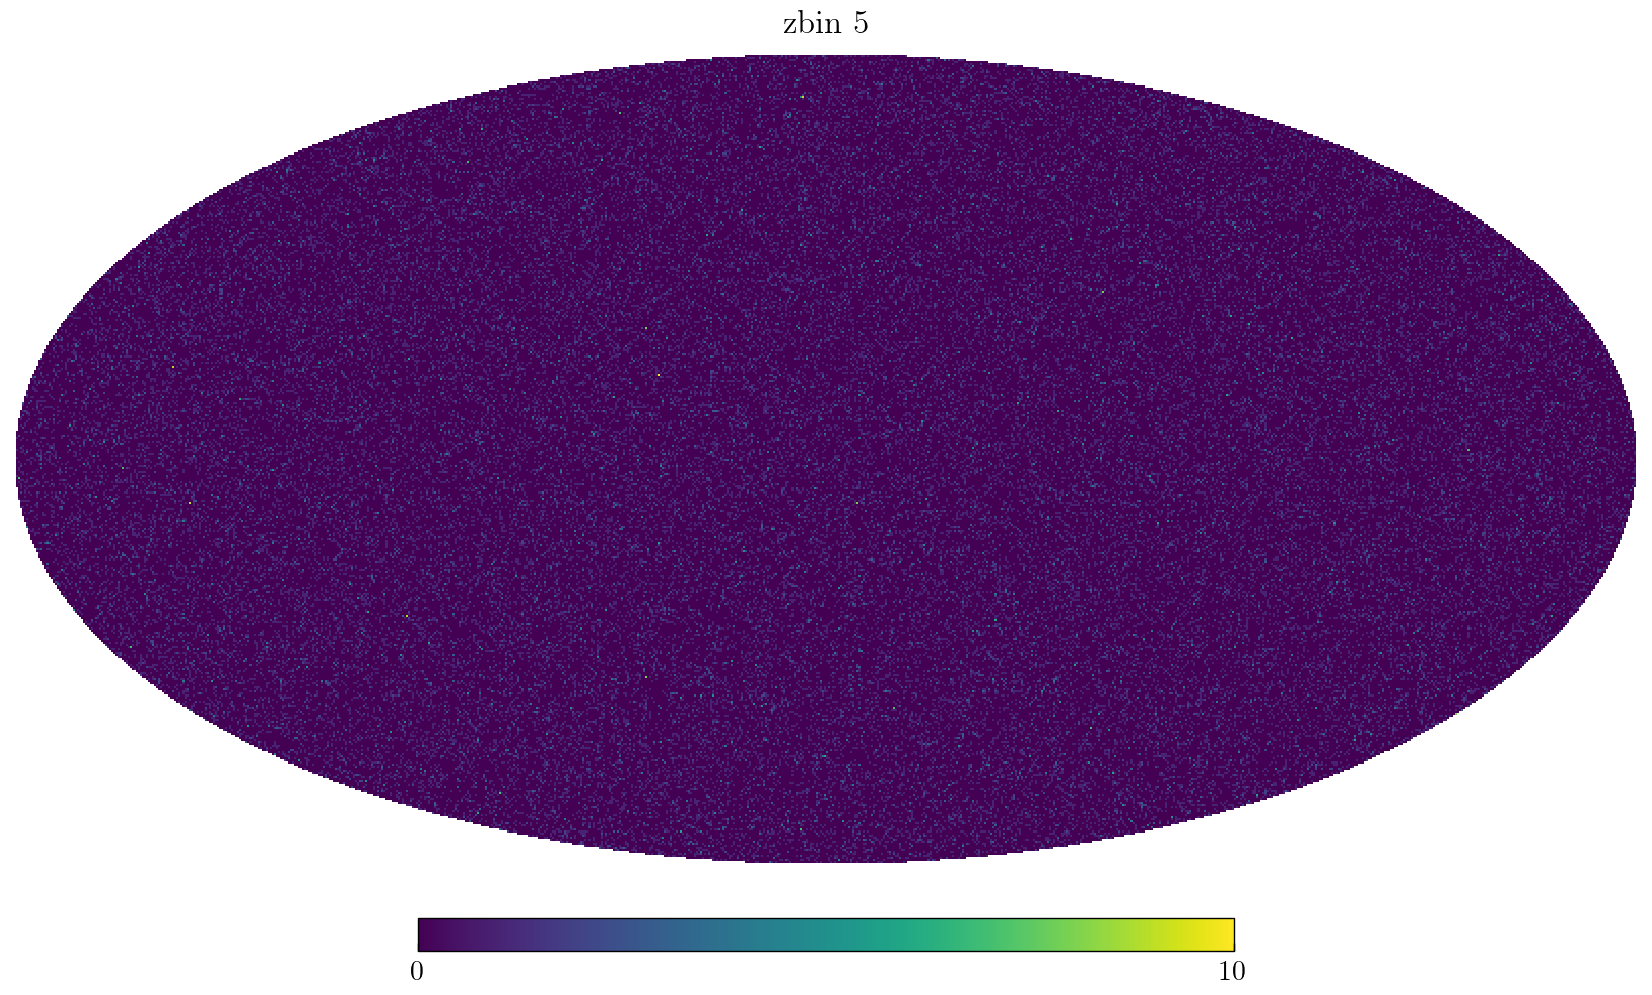

In [10]:
hp.mollview(mappa, title = f"zbin {zbin}")

In [11]:
for zbin in indices:
    el_fit, cl_fit = np.loadtxt(f"/home/users/d/darwish/ACTdr6xDESy3/actxdes/data/spectra_mnu_takahashi_fit/cl_kg_{zbin}.txt", unpack = True)

    plt.loglog(*bin_theory(hp.alm2cl(kappa_alm, deltas[zbin])), color = "blue", marker = "o")
    plt.plot(el_fit, cl_fit, label = "Takahashi", lw = 2)

    f = f"/home/users/d/darwish/ACTdr6xDESy3/notebooks/mice/mice_gg_{zbin}.txt"
    lbin, clmice, kgmice, shotmice = np.loadtxt(f).T

    plt.loglog(lbin, kgmice, label = "MICE", lw = 2, color = "green")

    plt.xlim(10, 1000)
    plt.ylim(1e-8, 3e-6)
    plt.show()

FileNotFoundError: /Users/omard/Downloads/spectra_mnu_takahashi_fit/cl_kg_0.txt not found.